# CS 598 Project: Part I - Nnet Regression Model Evaluation
## Alexander Asilador. 11/07/2020

Previously, I have tried to use a GAM to predict the angle in the z-axis (i.e. $\theta_z$). The results were lackluster.
Next, I tried to use Support Vector Regression to estimate theta_z. The results from estimating theta_z show an root mean square error of 12.71 degrees (test set). After conversations with the group, we are planning to first predict $\theta_x$ and $\theta_y$, based on a momentum-based model. We plan to do this by first calculating the momentum of the X and Y axis (**$M_x$** and **$M_y$** ) and substituting these terms  for the force sensors. 
Leo has shown good results in obtaining predicting $\theta_x$ and wants to make revisions to the sensor setup to give a more accurate calculation of M_y. In addition, a depth camera will be added to the setup to give us more information about the body position versus the four distance sensors, alone.
I added the **$M_x$** and **$M_y$** terms to the SVR model and obtained really good results in estimating $\theta_y$, but the model still struggles with prediction of $\theta_z$

Here, I decided to include the SVR model prediction of $\theta_y$ into the input feature and removing **$M_y$** after running the previous feature set into a saved SVR model. Unfortunately, I haven't yet employed $\theta_x$ into the model.

The Nnet Regression Model Takes the following as inputs:

| Inputs     | 
| :------------- | 
|Far left distance sensor (mm)|
|Center left distance sensor (mm)|
|Center right distance sensor (mm)|
|Far right distance sensor (mm)|
|Mx|
|thetahat_y|


where "thetahat_y" is the prediction of $\theta_y$ obtained from SVR (SVR model stored as svr_thetay_model.pkl). Note that scaling parameters sc_X and sc_Y were stored to evaluate the SVR model (Xsc_thetay.pkl and ysc_thetay.pkl)

Once the Neural Network is evaluated, the model weights are stored as "theta_zpred.h5", and the scaling terms are "Xsc_thetaz_nn.pkl" and "ysc_thetaz_nn.pkl". In addition, the indices for the random training/test sets are stored allow recall of previous results. They are stored as "randset_nn.pkl"

In [1]:
#change this folder
datadir = "C:/Users/Alex/Box Sync/CS598 - Final Project/Preliminary Data v2/Test_subject_Leo/"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from scipy import signal
import pickle
from sklearn.preprocessing import StandardScaler
import random
import tensorflow as tf


C:\ProgramData\Anaconda3\envs\SELDevalenv9\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\envs\SELDevalenv9\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\envs\SELDevalenv9\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\envs\SELDevalenv9\lib\site-

### Load all the data

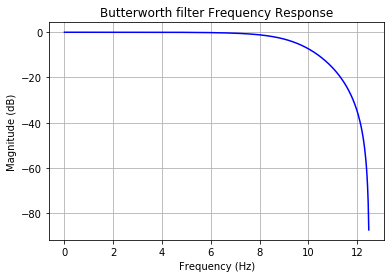

In [3]:
#Make a Butterworth filter with a 1 Hz cutoff
fs = 25
Wn= 9 #critical point 1 Hz. switched to 9 Hz to capture more information
butter_b,butter_a = signal.iirfilter(N=2, Wn=Wn, btype='lowpass',ftype='butter',fs=25,output='ba') #will use a zero-phase filtering to double the order
#signal.filtfilt
w,h = signal.freqz(b=butter_b, a=butter_a, worN=None, whole=False, plot=None);
fig=plt.figure()
freq = w*fs/(2*math.pi);
plt.plot(freq, 20 * np.log10(abs(h)), 'b');
plt.title('Butterworth filter Frequency Response')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.grid('on')
plt.show()

In [4]:
def readdata(datadir,foldername,datenm,pred='z',takelog_dsensor=True, moment_x=True,moment_y=True,filt=True, b=butter_b,a=butter_a):
    tmpstr = datadir+"/"+foldername+"/leo_"+foldername+"_"+datenm+"_fdss_final_data.txt"
    tmpstr2 = datadir+"/"+foldername+"/leo_"+foldername+"_"+datenm+"_qtm_final_data.txt"
    tmpdata = pd.read_csv(tmpstr)
    #filter before log
    if filt:
        tmpdata['Far left distance sensor (mm)']=signal.filtfilt(b,a,tmpdata['Far left distance sensor (mm)'])
        tmpdata['Center left distance sensor (mm)']=signal.filtfilt(b,a,tmpdata['Center left distance sensor (mm)'])
        tmpdata['Center right distance sensor (mm)']=signal.filtfilt(b,a,tmpdata['Center right distance sensor (mm)'])
        tmpdata['Far right distance sensor (mm)']=signal.filtfilt(b,a,tmpdata['Far right distance sensor (mm)'])
    
    if takelog_dsensor:
        tmpdata['Far left distance sensor (mm)']=np.log(tmpdata['Far left distance sensor (mm)'])
        tmpdata['Center left distance sensor (mm)']=np.log(tmpdata['Center left distance sensor (mm)'])
        tmpdata['Center right distance sensor (mm)']=np.log(tmpdata['Center right distance sensor (mm)'])
        tmpdata['Far right distance sensor (mm)']=np.log(tmpdata['Far right distance sensor (mm)'])
    
    if moment_y:
        d1 = 0.19
        d2 = 0.08
        g = 9.81
        if moment_x:
            tmpdata['My']= (tmpdata['Fx left (kg)'] + tmpdata['Fx right (kg)'])*d2*g
        else:
            tmpdata['My']= ((tmpdata['Fz left (kg)'] + tmpdata['Fz right (kg)'])*d1+ (tmpdata['Fx left (kg)'] + tmpdata['Fx right (kg)'])*d2)*g
        #try a part of momentum
        
        del tmpdata['Fx left (kg)']
        del tmpdata['Fx right (kg)']
    if moment_x:
        #Collapse Fz data to obtain theta_x
        d3 = 0.19
        g = 9.81
        tmpdata['Mx']= (tmpdata['Fz right (kg)'] - tmpdata['Fz left (kg)'])*d3*g
        
        del tmpdata['Fz left (kg)']
        del tmpdata['Fz right (kg)']

    #Reads-in the SVR Model for theta_y and also the Scaling Parameters        
    pkl_filename = "svr_thetay_model.pkl"
    with open(pkl_filename, 'rb') as file:
        est_thetay = pickle.load(file)
    pkl1_filename = "Xsc_thetay.pkl"
    with open(pkl1_filename, 'rb') as file:
        sc_X_thetay = pickle.load(file)
    pkl2_filename = "ysc_thetay.pkl"
    with open(pkl2_filename, 'rb') as file:
        sc_y_thetay = pickle.load(file)
    
    sc_X = StandardScaler()
    Xtest = tmpdata.values
    Xtest = sc_X_thetay.transform(Xtest)
    y_pred = est_thetay.predict(Xtest)
    y_pred1 = sc_y_thetay.inverse_transform(y_pred)

    
    tmpdata['thetahat_y']=y_pred1
    
    del tmpdata['My']
    
    if pred=='x':
        tmpdata2 = pd.read_csv(tmpstr2,usecols=["Lean Left/Right Angle (deg)"])
    
    if pred=='y':
        tmpdata2 = pd.read_csv(tmpstr2,usecols=["Lean Forward/Backwards Angle (deg)"])
        
    if pred=='z':
        tmpdata2 = pd.read_csv(tmpstr2,usecols=["Torso Twist Angle (deg)"])
        
    
        
    return pd.concat([tmpdata, tmpdata2],axis=1)

def create_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(6,)))
    model.add(tf.keras.layers.Dense(200, activation="relu"))
    model.add(tf.keras.layers.Dense(200, activation="relu"))
    model.add(tf.keras.layers.Dense(200, activation='relu')) #added extra layer. probably overkill but want good results
    model.add(tf.keras.layers.Dense(1, activation='linear'))
    model.compile(optimizer='adam',
              loss='mse',
              metrics=['mse','mae'])
    
    return model
    

In [5]:

datenm = "10_27_2020"
foldername = "test1"
x = readdata(datadir,foldername,datenm)
foldername = "test2"
x2 = readdata(datadir,foldername,datenm)
foldername = "test3"
x3 = readdata(datadir,foldername,datenm)
foldername = "test4"
x4 = readdata(datadir,foldername,datenm)
foldername = "test5"
x5 = readdata(datadir,foldername,datenm)
xfull = pd.concat([x, x2, x3, x4, x5], axis=0)

In [6]:
xfull.head()

,Far left distance sensor (mm),Center left distance sensor (mm),Center right distance sensor (mm),Far right distance sensor (mm),Mx,thetahat_y,Torso Twist Angle (deg)
0,4.762171,4.700507,4.634764,4.962843,4.175136,-5.782918,-2.854302
1,4.787843,4.691994,4.632544,4.990502,4.193775,-5.436540,-2.823818
2,4.751074,4.708508,4.634165,4.969046,4.119219,-5.792017,-2.805569
3,4.745392,4.704779,4.665645,4.979896,4.063302,-5.650691,-2.780234
4,4.720277,4.666549,4.670318,4.974725,3.988746,-6.077421,-2.749472


In [7]:
load_params=1 # (1): load previously trained Nnet Regression Model (0): Create new Nnet Regression Model to train
if load_params:
    #Load NNet Regression Model
    model=create_model()
    modelname = 'theta_zpred.h5'
    model.load_weights(modelname)

    #Load Scalers for input (X) and output (y)
    pkl1_filename = "Xsc_thetaz_nn.pkl"
    with open(pkl1_filename, 'rb') as file:
        sc_X = pickle.load(file)
    pkl2_filename = "ysc_thetaz_nn.pkl"
    with open(pkl2_filename, 'rb') as file:
        sc_y = pickle.load(file)
else:
    model = create_model()
    sc_X = StandardScaler()
    sc_y = StandardScaler()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [8]:
# Generate new set of random set or use previously set the neural net was trained under
load_prevset = 1 # (1): load previously trained Nnet Regression Model (0): Create new Nnet Regression Model to train

if load_prevset:
    pkl_filename = "randset_nn.pkl"
    with open(pkl_filename, 'rb') as file:
        randata = pickle.load(file)
    
    nsamps = randata['nsamps']
    n80p = randata['n80p']
    rannums = randata['rannums']
    test_set = randata['test_set']
else:
    nsamps = xfull.shape[0]
    n80p = int(np.floor(nsamps*0.8))
    rannums = np.array(random.sample(range(1,nsamps,1), n80p))
    s_nfiles = np.arange(nsamps)
    test_set = np.setdiff1d(s_nfiles,rannums)

In [9]:
#Create the files
Trainset = xfull.iloc[rannums,:]
Testset = xfull.iloc[test_set,:]

In [10]:
# Train the data
trainnnet = 0 # Switch to 1 to train new neural net
if trainnnet:
    Xtrainz = Trainset.iloc[:,:-1].values
    ytrainz = Trainset.iloc[:,-1:].values
    X = sc_X.fit_transform(Xtrainz)
    y = sc_y.fit_transform(ytrainz)
    epochs = int(1.3e5)
    batch_size = 128
    #callback allows tensorflow to quit early if the model doesn't improve in 500 iterations
    # callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=500) 
    ## trying to see if restore_best_weights will give better results
    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1000,restore_best_weights=True) #Moving to 1000 patience. 
    history = model.fit(
        X,
        y,
        callbacks=[callback],
        batch_size=batch_size,
        epochs=epochs,
        verbose=1,
    )



### 5-layer Network: Predict Against Training Data as a Sanity Check

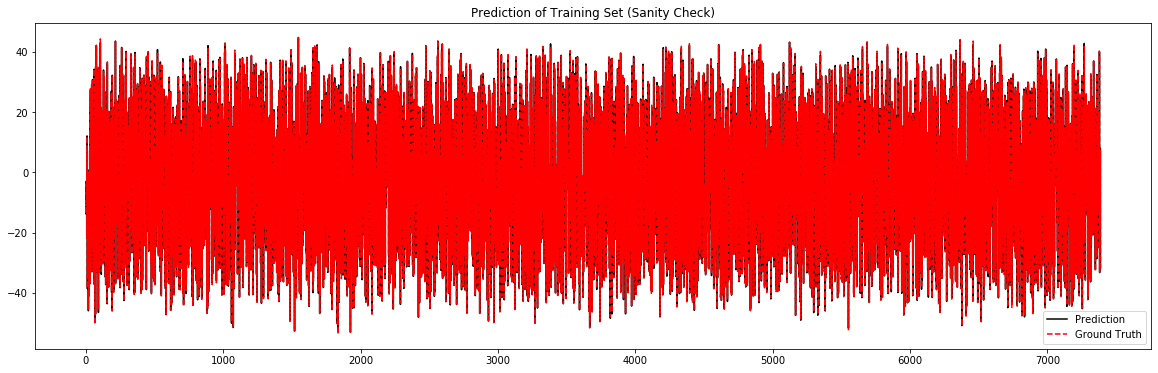

Average error is -0.03 degrees
Root Mean Squared Error is 0.27 degrees


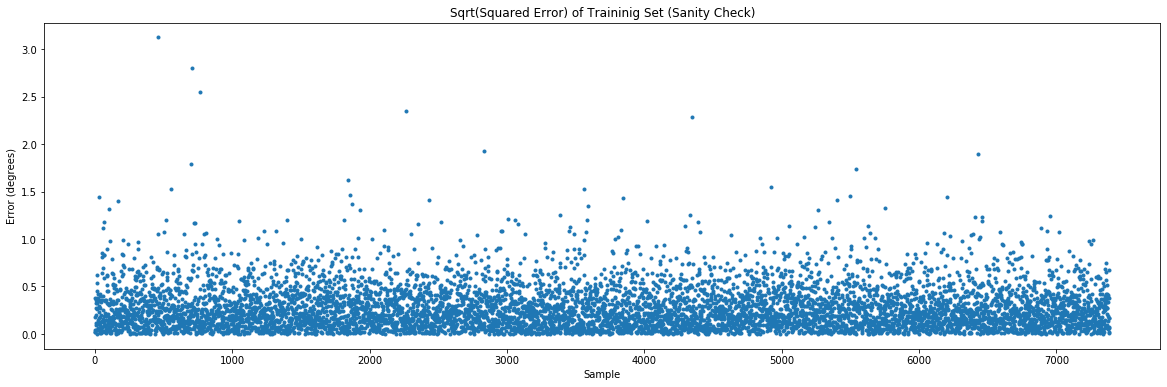

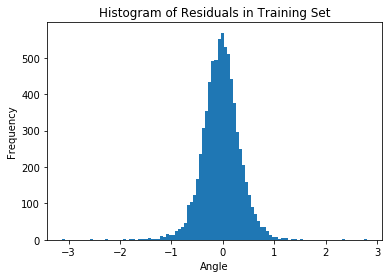

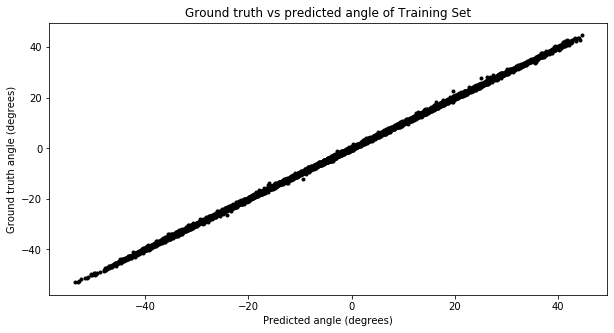

In [11]:
# sanity check with 80% data
Xtrain = Trainset.iloc[:,:-1].values
Xtrain = sc_X.transform(Xtrain)
y_pred = model.predict(Xtrain)
#y_pred = sc_y.inverse_transform(y_pred)
y_pred = sc_y.inverse_transform(y_pred)
y_new = Trainset.iloc[:,-1:].values
plt.figure(figsize=(20,6))
plt.plot(y_new,'k')
plt.plot(y_pred,'r--')
plt.title('Prediction of Training Set (Sanity Check)')
#plt.axis([xmin, xmax, ymin, ymax])
plt.legend(labels=['Prediction','Ground Truth'])
plt.show()
# Squared-root of Squared Error

test_error = (y_pred - y_new)
print('Average error is {:4.2f} degrees'.format(np.sum(test_error)/test_error.shape[0]))
rmse = np.sqrt(test_error**2)
print('Root Mean Squared Error is {:4.2f} degrees'.format(np.sum(rmse)/test_error.shape[0]))
plt.figure(figsize=(20,6))
plt.plot(rmse,'.')
plt.title('Sqrt(Squared Error) of Traininig Set (Sanity Check)')
plt.xlabel('Sample')
plt.ylabel('Error (degrees)')
plt.show()

plt.figure()
plt.hist(test_error,bins=100)
plt.title('Histogram of Residuals in Training Set')
plt.xlabel('Angle')
plt.ylabel('Frequency')
plt.show()

#plot scatterplot of data
plt.figure(figsize=(10,5))
plt.scatter(y_pred,y_new,marker='.',color='black')
plt.xlabel('Predicted angle (degrees)')
plt.ylabel('Ground truth angle (degrees)')
plt.title('Ground truth vs predicted angle of Training Set')
plt.show()


Here, it looks like the 5-layer neural network seems to be doing a good job at predicting the data it was trained to. I ran the code against the training set to make sure that the model is doing exactly what I want it to.

### 5-layer Neural Network: Predict Test Set

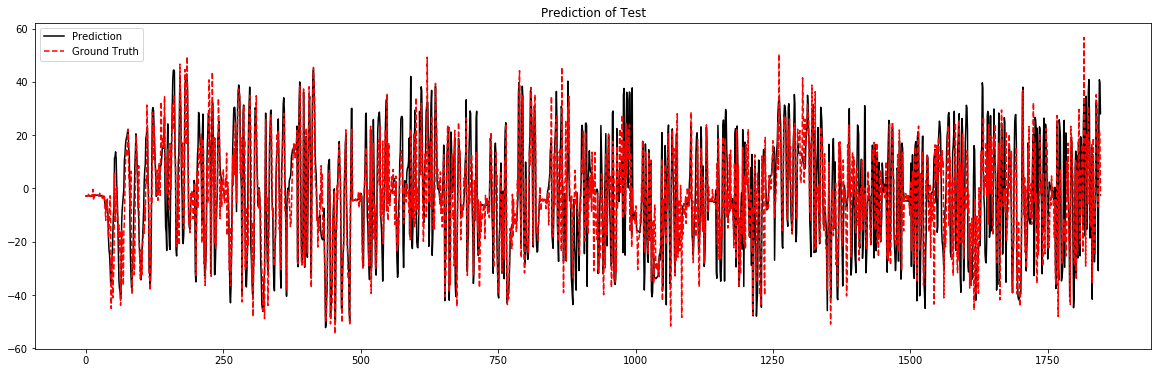

Average error is -0.68 degrees
Root Mean Squared Error is 9.80 degrees


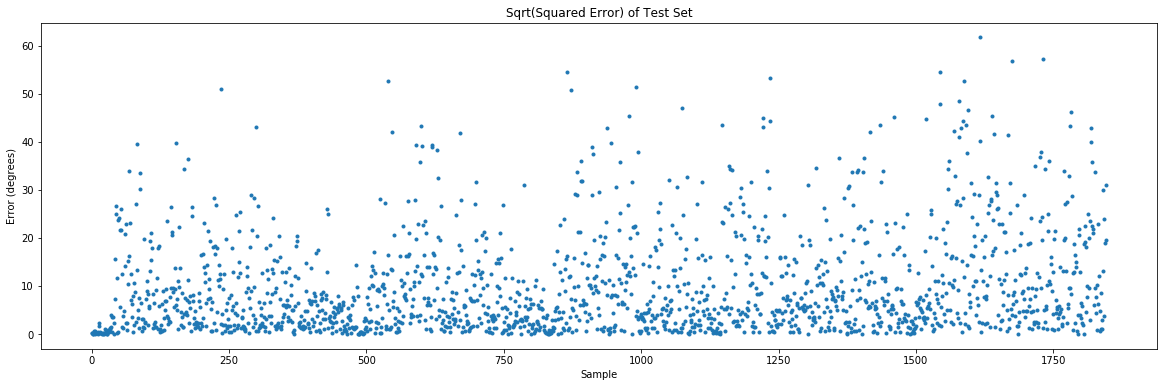

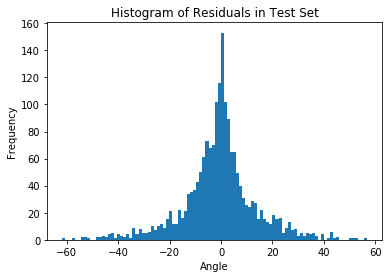

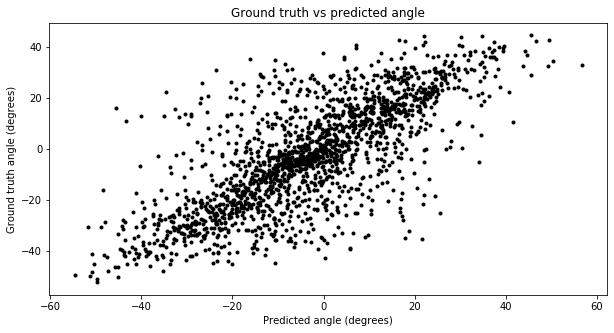

In [12]:
# Redo test set
Xtest = Testset.iloc[:,:-1].values
Xtest = sc_X.transform(Xtest)
y_pred = model.predict(Xtest)
y_pred = sc_y.inverse_transform(y_pred)
y_new = Testset.iloc[:,-1:].values

plt.figure(figsize=(20,6))
plt.plot(y_new,'k')
plt.plot(y_pred,'r--')
plt.title('Prediction of Test')
#plt.axis([xmin, xmax, ymin, ymax])
plt.legend(labels=['Prediction','Ground Truth'])
plt.show()

# Squared-root of Squared Error

test_error = (y_pred - y_new)
print('Average error is {:4.2f} degrees'.format(np.sum(test_error)/test_error.shape[0]))
rmse = np.sqrt(test_error**2)
print('Root Mean Squared Error is {:4.2f} degrees'.format(np.sum(rmse)/test_error.shape[0]))
plt.figure(figsize=(20,6))
plt.plot(rmse,'.')
plt.title('Sqrt(Squared Error) of Test Set')
plt.xlabel('Sample')
plt.ylabel('Error (degrees)')
plt.show()

plt.figure()
plt.hist(test_error,bins=100)
plt.title('Histogram of Residuals in Test Set')
plt.xlabel('Angle')
plt.ylabel('Frequency')
plt.show()

#plot scatterplot of data
plt.figure(figsize=(10,5))
plt.scatter(y_pred,y_new,marker='.',color='black')
plt.xlabel('Predicted angle (degrees)')
plt.ylabel('Ground truth angle (degrees)')
plt.title('Ground truth vs predicted angle')
plt.show()

Similar to the testing scheme created on the SVR implementation. The prediction of the test set shows that the model predicts the angle fairly well for the first 500 samples but seems to do worse in later samples. The reason why isn't inuitive to me since I the model has no memory of previous samples. Looking at the square root of the mean square error, the model doesn't perform much better than SVR model. In the SVR model, the error was 12.71 degrees. In the NNet model, the error is 9.80 degrees. While there is a 2 degree impovement, the model is still outside of the ideal range. Ideally, the error should be less than 7 degrees.

#### Post Saving of parameters

In [13]:
save_rannums = 0
if save_rannums:
    pkl_filename = "randset_nn.pkl"
    randata = {}
    randata['nsamps']=nsamps
    randata['n80p']=n80p
    randata['rannums']=rannums
    randata['test_set']=test_set
    with open(pkl_filename, 'wb') as file:
        pickle.dump(randata, file)

In [14]:
saveparams = 0

if saveparams:
    model.save('theta_zpred.h5') 
    
    pkl_filename = "Xsc_thetaz_nn.pkl"
    with open(pkl_filename, 'wb') as file:
        pickle.dump(sc_X, file)

    pkl_filename = "ysc_thetaz_nn.pkl"
    with open(pkl_filename, 'wb') as file:
        pickle.dump(sc_y, file)